In [79]:
import pandas as pd

In [80]:
colnames = [
    "source_address", "source_port", "destination_address", "destination_port",
    "mode", "interval", "transferred_bytes", "bits_per_second"
]
df_a = pd.read_csv("data/loga.csv", names=colnames, index_col=0)
df_b = pd.read_csv("data/logb.csv", names=colnames, index_col=0)


<AxesSubplot:>

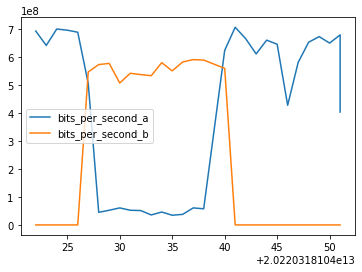

In [81]:
df = pd.merge(df_a["bits_per_second"],
              df_b["bits_per_second"],
              left_index=True,
              right_index=True,
              suffixes=("_a", "_b"),
              how="outer").fillna(0)
df.plot()
